**Exploration of Hidden Relationships Between Organizational Patterns through Softmax Regression as Multi-layer Perceptron**

This neural network is designed to classify organizational patterns / pattern languages or organizational pattern sequences. Index of a probability prediction as output from a Softmax regression with a highest probability is pattern classification you're searching for. Our task here is to find whether we can calculate probabilities and likelihood of the organizational patterns based on the frequencies of the words with which they are documented.

This work is a continuation of previous research conducted by Waseeb et al. in 'Extracting Relations Between Organizational Patterns Using Association Mining' which you can find here: http://www2.fiit.stuba.sk/~vranic/pub/ExtractingRelations.pdf. Dataset we're working on is quite similar to the one on page 4. Table 1 titled as "A matrix sample values for n-gram existence against org. patterns" but we use TF-IDF frequencies instead of binary-encoded attributes.

Sample dataset with frequencies of 11 bigrams found in textual descriptions of the organizational patterns from http://www.orgpatterns.com/ has been provided in Excel sheets.

<u>Model output example</u>:

Training dataset consists of frequencies of the bigrams for 18 organizational patterns. Output from this Artificial Neural Network is a vector for a pattern with frequencies from a validation and test dataset with as many components as there are patterns in a training dataset:

for a $pattern_{i}$ = (x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14, x15, x16, x17, x18),

where $x_{i}$ is output from a softmax regression and it's a likelihood of this pattern given observed frequencies for n-gram.
Biggest value or highest probability from this vector is a classification of the set of the n-gram inverse frequencies of a given organizational pattern.

**Main Idea of our Approach**

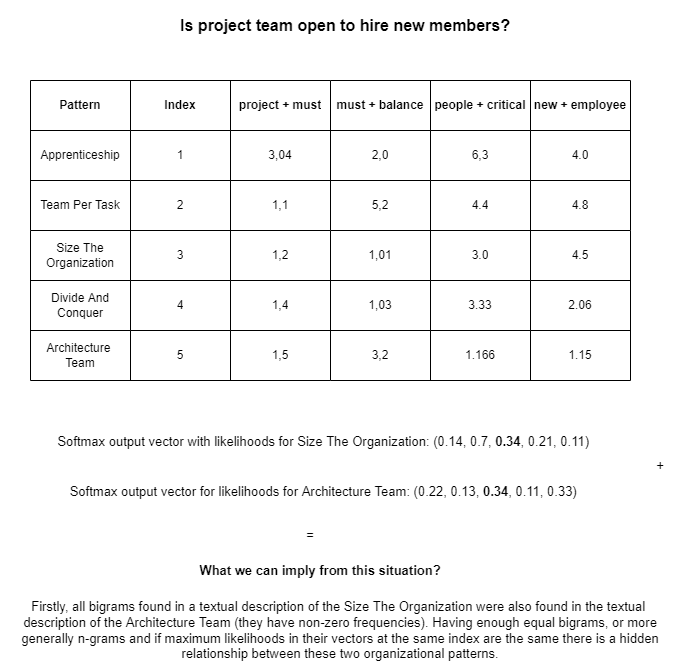

Training test and validation datasets consist of the same 11 bigrams, or attributes. Validation dataset should be used to optimalize hyperparameters (parameters which are not trained during computation of this ANN) and test dataset shall be used only once.

Please note that prediction is correct if it is consistent with an actual class. Accuracy of the model is one of the metrics used to evaluate this behavior.

Theory behind this can be found in a book Dive into Deep Learning: https://d2l.ai/chapter_linear-networks/softmax-regression.html

In [7]:
import tensorflow as tf
# keras is facade for tensorflow so we don't have to deal with low-level API
from tensorflow import keras 
from tensorflow.keras.models import Sequential # composite pattern for building neural network
from tensorflow.keras.layers import Dense # input, hidden and output layer
from tensorflow.keras.losses import categorical_crossentropy # loss function
from keras.utils.np_utils import to_categorical # hot-encoding for softmax regression
from tensorflow.keras.optimizers import Adam # optimalizer for neural network

# library for data preprocessing and model evaluation
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

import numpy as np # to handle data compactly
import pandas as pd
import matplotlib.pyplot as plt # plotting library

tf.keras.backend.clear_session()

train_df = pd.read_excel('bigram-pattern-frequencies-train.xlsx', engine='openpyxl')
val_df = pd.read_excel('bigram-pattern-frequencies-val.xlsx', engine='openpyxl')
test_df = pd.read_excel('bigram-pattern-frequencies-test.xlsx', engine='openpyxl')

**Normalization of organizational patterns bigram frequencies**

Why? Because some of the bigrams (independent variables, attributes X) have higher frequencies than the others. This means they are used often in pattern descriptions than those used less. We will normalize these attributes so they contribute equally to the model training process. Normalization is often a must be to get acceptable results from machine learning or deep learning models.

Because some of the bigrams are used more often than the others they differ in a (statistical) variance. This means they must be normalized because of this fact too. It's not very good to increase learning rate (as one of the hyperparameters of this neural network) when attributes are not normalized before. This could lead to divergency, when we wouldn't be able to find best parameters from this training process.

Good news is we don't have to weigth our labels (indexes representing organizational patterns) since each class (organizational pattern) is represented once in our working dataset.

In [8]:
number_of_patterns = 19

train_scaler = StandardScaler()
train_without_target = train_df.drop(['PatternIndex'], axis=1)
train_without_pattern_name = train_without_target.drop(['OrganizationalPattern'], axis=1)
train_features = train_scaler.fit(train_without_pattern_name.values)

X_train = pd.DataFrame(train_scaler.transform(train_df.iloc[:, 1:-1].values))
y_train = to_categorical(train_df.iloc[:,-1].values, number_of_patterns) # hot-encoding label (pattern index) for softmax regression

val_scaler = StandardScaler()
val_without_target = val_df.drop(['PatternIndex'], axis=1)
val_without_pattern_name = val_without_target.drop(['OrganizationalPattern'], axis=1)
val_features = val_scaler.fit(val_without_pattern_name.values)

X_val = pd.DataFrame(val_scaler.transform(val_df.iloc[:, 1:-1].values))
y_val = to_categorical(val_df.iloc[:,-1].values, number_of_patterns)

test_scaler = StandardScaler()
test_without_target = test_df.drop(['PatternIndex'], axis=1)
test_without_pattern_name = test_without_target.drop(['OrganizationalPattern'], axis=1)
test_features = test_scaler.fit(test_without_pattern_name.values)

X_test = pd.DataFrame(test_scaler.transform(test_df.iloc[:, 1:-1].values))
y_test = to_categorical(test_df.iloc[:,-1].values, number_of_patterns)  

**Softmax Regression - Classification of the patterns based on the n-gram frequencies**

Activation functions are those components in neural network which are responsible to generate output from a network. Combination of linear functions (layers of the ANN without these functions perform affine transformations only) is stil a linear function. That's why we need non-linear activation function. Non-linear activation functions help us to take advantage of the GPU processing capabilities.

ReLU is one of the standard activation functions used in the neural networks. Softmax is activation function too. Number passed as argument to the constructor of the layer of our Artificial Neural Network is number of perceptrons on this layer. Dropout layer is used as regularization technique to eliminate overfitting of the model on training dataset.

First dense layer is our input layer, or layer to consume our dataset. It has 11 neurons, because we have 11 bigrams in our training dataset. Last layer is output layer of this neural network. All layers between are hidden layers of this network. All layers are fully connected layers of this Multi-layer perceptron.

What we're doing here? Well, we go through these steps for 100 epochs:

 1. we pass here our dataset
 2. we declare ANN as MLP. See https://d2l.ai/chapter_multilayer-perceptrons/index.html
 3. we declare optimizer which we want to use. It's Adam, best in class: https://arxiv.org/pdf/1412.6980.pdf
 4. we work with-minibatches. We optimize model parameters passing each 4 rows in our dataset.
 5. we perform forward pass through this network. This means we generate predictions.
 6. we compute loss of the prediction
 7. we propagate back this loss through all the layers of ANN. In fact we propagate gradients.
 8. then we use these parameters for another forward pass of this MLP.

At the end we use one of the standards visualization techniques for model evaluation.

In [9]:
model = tf.keras.Sequential([
  tf.keras.layers.Dense(11, activation="relu"),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(19, activation="softmax")
])


model.compile(optimizer='adam',
                loss=categorical_crossentropy,
                metrics=["accuracy"])

BATCH_SIZE = 4
EPOCHS = 100
SHUFFLE = True

history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data = (X_val, y_val), shuffle=SHUFFLE)

Epoch 1/100
5/5 [==============================] - 1s 45ms/step - loss: 2.9736 - accuracy: 0.0000e+00 - val_loss: 2.9610 - val_accuracy: 0.1429
Epoch 2/100
5/5 [==============================] - 0s 8ms/step - loss: 2.9589 - accuracy: 0.0556 - val_loss: 2.9547 - val_accuracy: 0.1429
Epoch 3/100
5/5 [==============================] - 0s 8ms/step - loss: 2.9431 - accuracy: 0.0556 - val_loss: 2.9539 - val_accuracy: 0.1429
Epoch 4/100
5/5 [==============================] - 0s 10ms/step - loss: 2.9678 - accuracy: 0.0000e+00 - val_loss: 2.9513 - val_accuracy: 0.1429
Epoch 5/100
5/5 [==============================] - 0s 8ms/step - loss: 2.9557 - accuracy: 0.0000e+00 - val_loss: 2.9467 - val_accuracy: 0.1429
Epoch 6/100
5/5 [==============================] - 0s 10ms/step - loss: 2.9448 - accuracy: 0.0556 - val_loss: 2.9428 - val_accuracy: 0.1429
Epoch 7/100
5/5 [==============================] - 0s 10ms/step - loss: 2.9151 - accuracy: 0.0556 - val_loss: 2.9412 - val_accuracy: 0.1429
Epoch 8/100

We still have a low accuracy (bias) mostly because we still deal with a very small dataset. Loss here is a value of the cost function (losses for all predictions). Val_loss is a model variance.

Because loss is lower than the validation loss (but not significantly) we can say our probability prediction model is overfitting. This is why we have employed one of the regularization techniques for neural networks - we added Dropout layer. Documentation for this approach can be found in the work of Srivastava et al. Dropout - A Simple Way to Prevent Neural Networks from Overfitting which you can find here https://jmlr.org/papers/v15/srivastava14a.html

**ANN Training Visualization**

Accuracy goes up with epochs which is intended behavior.

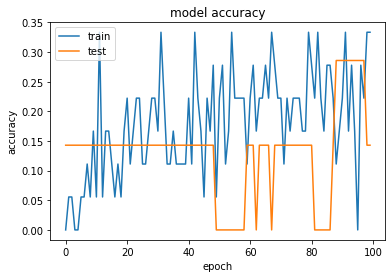

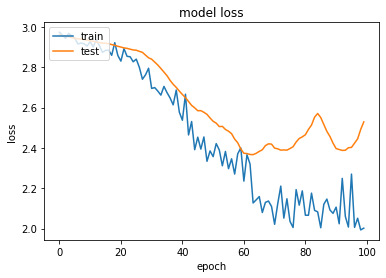

In [10]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**How do we encode knowledge**

According to https://www.quora.com/How-do-you-calculate-the-number-of-parameters-of-an-MLP-neural-network our ANN has 11*30 + (30*30 + 30*30) + 19*30 + (30 + 30 + 30 + 19) = 2809 learning parameters.

Or using another formula

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 11)                132       
                                                                 
 dense_1 (Dense)             (None, 30)                360       
                                                                 
 dense_2 (Dense)             (None, 30)                930       
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense_3 (Dense)             (None, 30)                930       
                                                                 
 dense_4 (Dense)             (None, 19)                589       
                                                                 
Total params: 2,941
Trainable params: 2,941
Non-trainabl

**MLP evaluation**

Now we have to evaluate our classification model. Non-overfitting softmax regression model for us is a model with roughly same accuracy on the training, validation and test dataset. Visualization through the confusion matrix will help us evaluate model performance on these three types of the data sets.

So now we're going to check our classification accuracy on the training dataset. For evaluation we use a confusion matrix. Confusion matrix consists from the ones and zeros because in our case because each organizational pattern in a dataset is represented exactly once. This could be changed by processing other pattern descriptions from numerous sources but always 
for the same set of the patterns. Ones are visible at those places where model has classified pattern according to inverse n-gram frequencies.

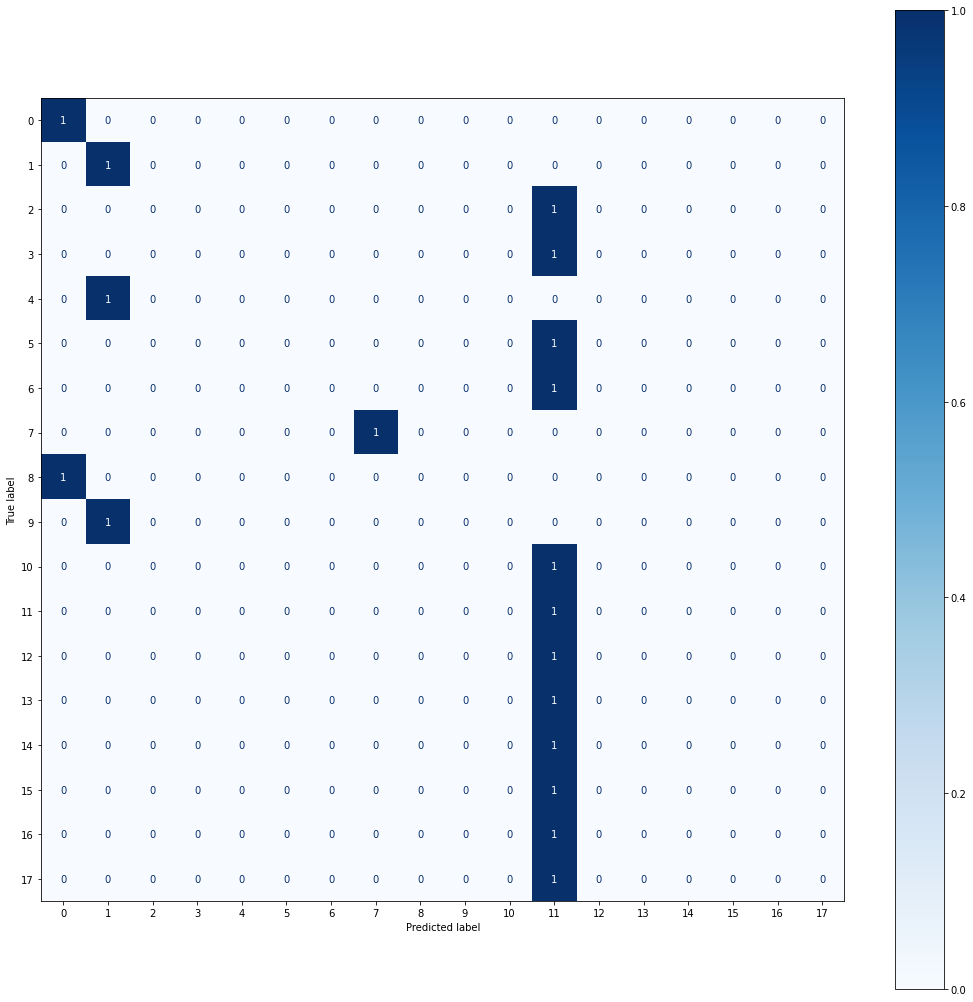

In [12]:
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(18, 18))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(18))
    cm.plot(values_format='d', cmap='Blues', ax=ax)
    
train_set_probabilities_for_classes = model.predict(X_train)
# class with a maximum probability is our predicted quality class
train_set_predicted_classes = np.argmax(train_set_probabilities_for_classes, axis = 1)
y_train_class = np.argmax(y_train, axis = 1)
confusion_matrix(y_train_class, train_set_predicted_classes)

plot_confusion_matrix(y_train_class, train_set_predicted_classes)

** Model Evaluation **

HierarchyOfFactories organizational pattern (pattern 10) has been classified to the same category as Deploy Along The Grain organizational pattern is (pattern 15). This is good because they are from the same pattern language "People and Code Pattern Language". One of the rules of neural networks says that inputs from the same class should be represented similarly and should be classified to the same class or category.

HierarchyOfFactories and Deploy Along The Grain organizational patterns are represented with a same set of the layers and neurons.